# Quantum Phase Estimation

We will now demonstrate an example for Phase Estimation using Hadamard Test using Qiskit for a phase gate as shown below.

## Hadamard Test

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_distribution
from qiskit.circuit.library import UnitaryGate, PhaseGate, Initialize, SwapGate
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
import numpy as np

In [20]:
def Hadamard_test(unitary, evec, epsilon = 0.001, delta=0.01, backend = AerSimulator(), optimization_level=3):

    '''
    Hadamard Test for a given unitary operator and eigenvector.

    Parameters:
    unitary (QuantumCircuit): The unitary operator/gate to be tested.
    evec (Statevector): The eigenvector of the unitary operator.
    epsilon (float): The desired precision for the real part of the eigenvalue.
    1 - delta (float): The success probability.
    backend (Backend): The quantum backend to run the circuit on.
    optimization_level (int): The optimization level for the circuit transpilation.
    '''

    qubits = QuantumRegister(unitary.num_qubits+1, 'q')
    cbits = ClassicalRegister(1, 'c')
    qc_re = QuantumCircuit(qubits, cbits)
    zero = Statevector.from_label('0')
    initial_state = evec.tensor(zero)
    initialize_state = Initialize(initial_state)

    print("Parameters of Hadamard Test:")
    print("Backend:", backend)
    print("Unitary:", unitary)
    print("Epsilon:", epsilon)
    print("Success Probability:", 1-delta)
    print("Eigenvector:", evec)
    print("Initial state:", initial_state)
    print("Optimization Level:", optimization_level)
    unitary = UnitaryGate(unitary, label='U').control(1)
    
    # Real Hadamard Test
    qc_re.append(initialize_state, range(0,unitary.num_qubits))
    qc_re.barrier()
    qc_re.h(0)
    qc_re.append(unitary,range(0,unitary.num_qubits))
    qc_re.h(0)
    qc_re.barrier()
    qc_re.measure(0,0)

    # Shots
    shots_re = int((1/epsilon**2) * np.log(1/(delta)))
    # shots_re = shots

    # Run the circuit
    pm = generate_preset_pass_manager(backend=backend, optimization_level=optimization_level)
    isa_qc_re = pm.run(qc_re)
    isa_qc_re.draw(output='mpl')
    sampler=Sampler(mode=backend)
    sampler.options.default_shots = shots_re
    results_re = sampler.run([isa_qc_re]).result()
    # results_re = backend.run(isa_qc_re, shots=shots_re).result()
    counts_re = results_re.get_counts(isa_qc_re)
    if '0' in counts_re:
        real = (2*counts_re['0']/shots_re)-1
    else:
        real = 0

    # Imaginary Hadamard Test
    qc_im = QuantumCircuit(qubits, cbits)
    qc_im.append(initialize_state, range(0,unitary.num_qubits))
    qc_im.barrier()
    qc_im.h(0)
    qc_im.sdg(0)
    qc_im.append(unitary, range(0,unitary.num_qubits))
    qc_im.h(0)
    qc_im.barrier()
    qc_im.measure(0,0)

    # Shots
    shots_im = 100
    pm = generate_preset_pass_manager(backend=backend, optimization_level=optimization_level)
    isa_qc_im = pm.run(qc_im)
    sampler=Sampler(backend=backend)
    sampler.options.default_shots = shots_im
    results_im = sampler.run([isa_qc_im]).result()
    # results_im = backend.run(isa_qc_im, shots=shots_im).result()
    counts_im = results_im.get_counts(isa_qc_im)
    if '0' in counts_im:
        imaginary = (2*counts_im['0']/shots_im)-1
    else:
        imaginary = 0

    if imaginary < 0:
        angle = 1- (np.arccos(real)/(2*np.pi))
    else:
        angle = np.arccos(real)/(2*np.pi)

    return angle, qc_re ,qc_im, isa_qc_re, isa_qc_im, shots_re, shots_im, results_re, results_im, counts_re, counts_im, real, imaginary

### Example 1: Phase Gate Demonstration

In [21]:
unitary = PhaseGate(2*np.pi*0.1234)
evec = Statevector.from_label('1')
backend = AerSimulator()
epsilon = 0.001
delta = 0.01
shots =1000
optimization_level = 3

In [23]:
angle, qc_re, qc_im, isa_qc_re, isa_qc_im, shots_re, shots_im, results_re, results_im, counts_re, counts_im, real, imaginary = Hadamard_test(unitary=unitary, evec=evec, epsilon=epsilon, delta=delta, backend=backend, optimization_level=optimization_level)

Parameters of Hadamard Test:
Backend: AerSimulator('aer_simulator')
Unitary: Instruction(name='p', num_qubits=1, num_clbits=0, params=[0.775345066905961])
Epsilon: 0.001
Success Probability: 0.99
Eigenvector: Statevector([0.+0.j, 1.+0.j],
            dims=(2,))
Initial state: Statevector([0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
            dims=(2, 2))
Optimization Level: 3


AttributeError: 'PrimitiveResult' object has no attribute 'get_counts'

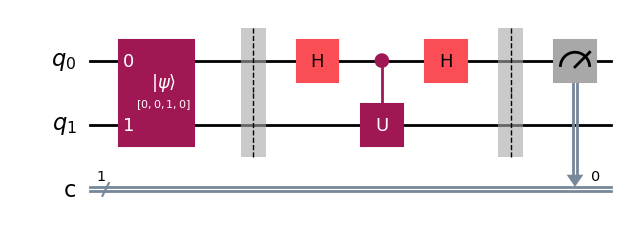

In [29]:
qc_re.draw(output='mpl')

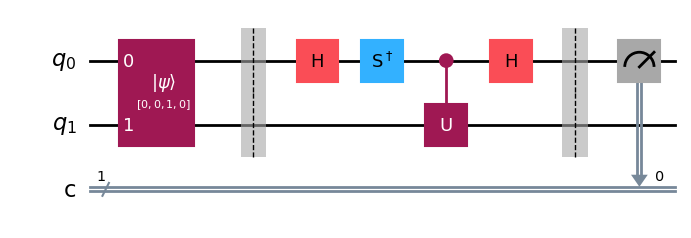

In [30]:
qc_im.draw(output='mpl')

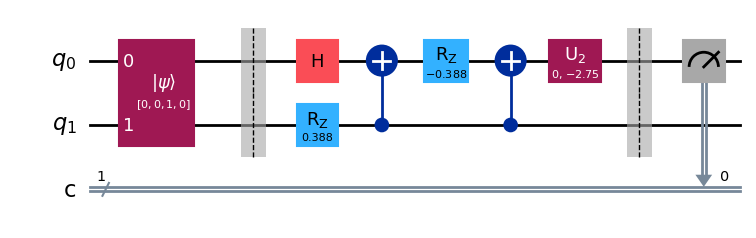

In [31]:
isa_qc_re.draw(output='mpl')

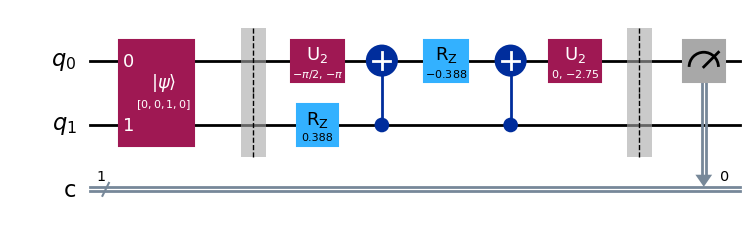

In [32]:
isa_qc_im.draw(output='mpl')

In [33]:
results_re

Result(backend_name='aer_simulator', backend_version='0.15.0', qobj_id='', job_id='2ec5f8be-2a9e-4742-85f1-66f0838ac730', success=True, results=[ExperimentResult(shots=1000, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 863, '0x1': 137}), header=QobjExperimentHeader(creg_sizes=[['c', 1]], global_phase=0.0, memory_slots=1, n_qubits=2, name='circuit-226', qreg_sizes=[['q', 2]], metadata={}), status=DONE, seed_simulator=1916793971, metadata={'batched_shots_optimization': False, 'required_memory_mb': 1, 'method': 'statevector', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 1, 'time_taken': 0.0079861, 'sample_measure_time': 0.0040446, 'input_qubit_map': [[0, 0], [1, 1]], 'max_memory_mb': 7876, 'measure_sampling': True, 'noise': 'ideal', 'parallel_shots': 1, 'parallel_state_update': 12, 'runtime_parameter_bind': False, 'num_bind_params': 1, 'fusion': {'enabled': True, 'threshold': 14, 'max_fused_qubits': 5, 'ap

In [34]:
results_im

Result(backend_name='aer_simulator', backend_version='0.15.0', qobj_id='', job_id='74f06080-9a89-4c79-9665-a350fc5f4ea9', success=True, results=[ExperimentResult(shots=100, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 88, '0x1': 12}), header=QobjExperimentHeader(creg_sizes=[['c', 1]], global_phase=0.0, memory_slots=1, n_qubits=2, name='circuit-244', qreg_sizes=[['q', 2]], metadata={}), status=DONE, seed_simulator=3269698036, metadata={'batched_shots_optimization': False, 'required_memory_mb': 1, 'method': 'statevector', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 1, 'time_taken': 0.0012589, 'sample_measure_time': 0.0002176, 'input_qubit_map': [[0, 0], [1, 1]], 'max_memory_mb': 7876, 'measure_sampling': True, 'noise': 'ideal', 'parallel_shots': 1, 'parallel_state_update': 12, 'runtime_parameter_bind': False, 'num_bind_params': 1, 'fusion': {'enabled': True, 'threshold': 14, 'max_fused_qubits': 5, 'appli

In [35]:
counts_re

{'0': 863, '1': 137}

In [36]:
counts_im

{'0': 88, '1': 12}

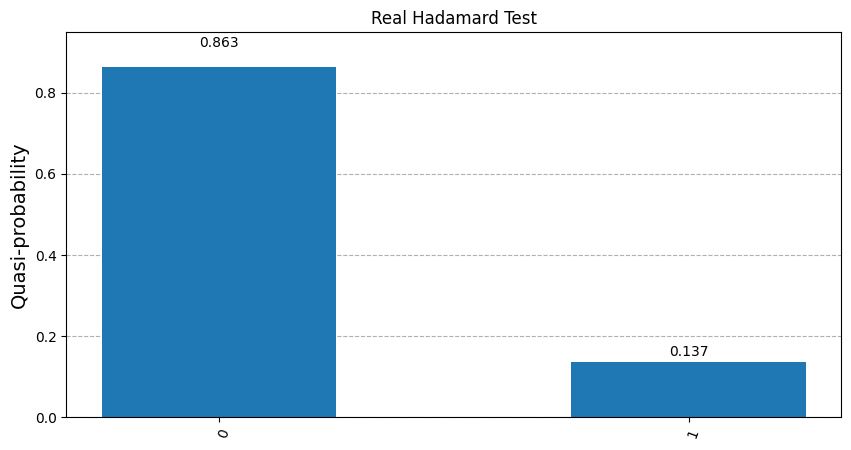

In [37]:
plot_distribution(results_re.get_counts(qc_re), title="Real Hadamard Test", figsize=(10, 5))

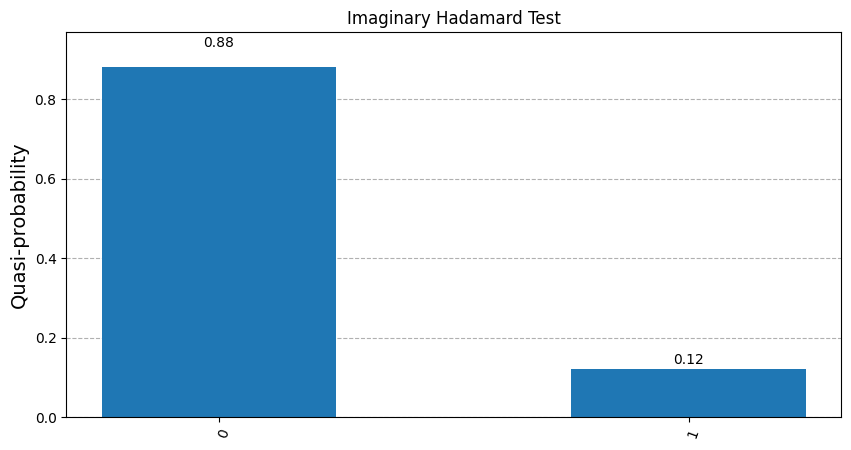

In [38]:
plot_distribution(results_im.get_counts(qc_im), title="Imaginary Hadamard Test", figsize=(10, 5))

In [ ]:
print("The Hadamard Test")
print("Real part of eigenvalue:", real)
print("Imaginary part of eigenvalue:", imaginary)
print("Angle:", angle)
print("Eigenvalue:", np.exp(2*np.pi*1j*angle))
print("Real p(0):", counts_re['0']/shots_re)
print("Real p(1):", counts_re['1']/shots_re)
print("Imaginary p(0):", counts_im['0']/shots_im)
print("Imaginary p(1):", counts_im['1']/shots_im)


Real part of eigenvalue: 0.726
Imaginary part of eigenvalue: 0.76
Angle: 0.12068861186026493
Eigenvalue: (0.726+0.6876946997032913j)
Real p(0): 0.863
Real p(1): 0.137
Imaginary p(0): 0.88
Imaginary p(1): 0.12


In [41]:
print(f'PhaseEstimation angle: {angle} with shots={shots} and success probabiltiy={1-delta}')

PhaseEstimation angle: 0.12068861186026493 with shots=1000 and success probabiltiy=0.99


In [109]:
unitary = PhaseGate(2*np.pi*0.1234)
evec = Statevector.from_label('1')
backend = AerSimulator()
epsilon = 0.001
delta = 0.01
shots =1000
optimization_level = 3

In [110]:
shots_had_sim_1234 = [2,4,8,10,16,20,32,50,100,200,500,1000,2000,5000,10000,20000,50000,100000,200000,500000,1000000]
error_had_sim_1234 = []
for shot in shots_had_sim_1234:
    angle, qc_re, qc_im, isa_qc_re, isa_qc_im, shots_re, shots_im, results_re, results_im, counts_re, counts_im, real, imaginary = Hadamard_test(unitary=unitary, evec=evec, epsilon=epsilon, delta=delta, shots=shot, backend=backend, optimization_level=optimization_level)
    error_had_sim_1234.append(abs(angle-0.1234))


Parameters of Hadamard Test:
Backend: AerSimulator('aer_simulator')
Unitary: Instruction(name='p', num_qubits=1, num_clbits=0, params=[0.775345066905961])
Epsilon: 0.001
Success Probability: 0.99
Eigenvector: Statevector([0.+0.j, 1.+0.j],
            dims=(2,))
Initial state: Statevector([0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
            dims=(2, 2))
Optimization Level: 3
Parameters of Hadamard Test:
Backend: AerSimulator('aer_simulator')
Unitary: Instruction(name='p', num_qubits=1, num_clbits=0, params=[0.775345066905961])
Epsilon: 0.001
Success Probability: 0.99
Eigenvector: Statevector([0.+0.j, 1.+0.j],
            dims=(2,))
Initial state: Statevector([0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
            dims=(2, 2))
Optimization Level: 3
Parameters of Hadamard Test:
Backend: AerSimulator('aer_simulator')
Unitary: Instruction(name='p', num_qubits=1, num_clbits=0, params=[0.775345066905961])
Epsilon: 0.001
Success Probability: 0.99
Eigenvector: Statevector([0.+0.j, 1.+0.j],
            dims=(2,)

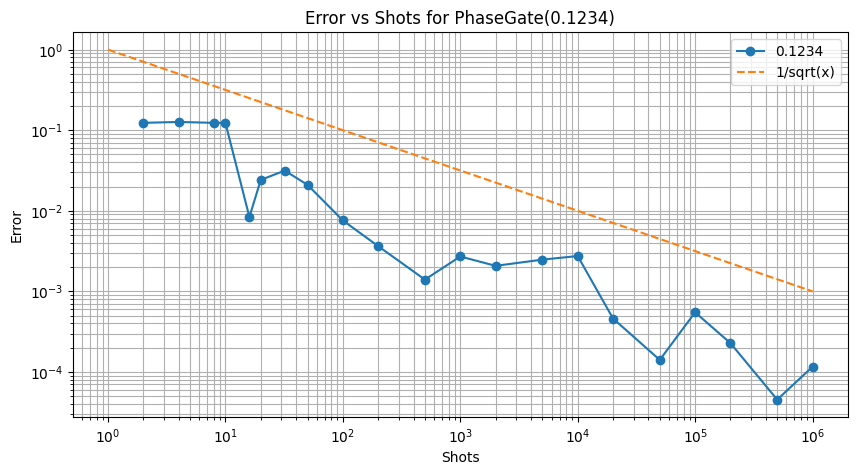

In [111]:
# PLot error vs shots
plt.figure(figsize=(10, 5))
plt.plot(shots_had_sim_1234, error_had_sim_1234, marker='o', label='0.1234')
x = np.linspace(1,1000000,1000)
y = 1/np.sqrt(x)
plt.plot(x, y, label='1/sqrt(x)', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Shots')
plt.ylabel('Error')
plt.title('Error vs Shots for PhaseGate(0.1234)')
plt.grid(which='both')
plt.legend()
plt.show()

In [4]:
unitary = PhaseGate(2*np.pi*0.5625)
evec = Statevector.from_label('1')
backend = AerSimulator()
epsilon = 0.001
delta = 0.01
shots =1000
optimization_level = 3

In [113]:
shots_had_sim_5625 = [2,4,8,10,16,20,32,50,100,200,500,1000,2000,5000,10000,20000,50000,100000,200000,500000,1000000]
error_had_sim_5625 = []
for shot in shots_had_sim_5625:
    angle, qc_re, qc_im, isa_qc_re, isa_qc_im, shots_re, shots_im, results_re, results_im, counts_re, counts_im, real, imaginary = Hadamard_test(unitary=unitary, evec=evec, epsilon=epsilon, delta=delta, shots=shot, backend=backend, optimization_level=optimization_level)
    error_had_sim_5625.append(abs(angle-0.5625))

Parameters of Hadamard Test:
Backend: AerSimulator('aer_simulator')
Unitary: Instruction(name='p', num_qubits=1, num_clbits=0, params=[3.5342917352885173])
Epsilon: 0.001
Success Probability: 0.99
Eigenvector: Statevector([0.+0.j, 1.+0.j],
            dims=(2,))
Initial state: Statevector([0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
            dims=(2, 2))
Optimization Level: 3
Parameters of Hadamard Test:
Backend: AerSimulator('aer_simulator')
Unitary: Instruction(name='p', num_qubits=1, num_clbits=0, params=[3.5342917352885173])
Epsilon: 0.001
Success Probability: 0.99
Eigenvector: Statevector([0.+0.j, 1.+0.j],
            dims=(2,))
Initial state: Statevector([0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
            dims=(2, 2))
Optimization Level: 3
Parameters of Hadamard Test:
Backend: AerSimulator('aer_simulator')
Unitary: Instruction(name='p', num_qubits=1, num_clbits=0, params=[3.5342917352885173])
Epsilon: 0.001
Success Probability: 0.99
Eigenvector: Statevector([0.+0.j, 1.+0.j],
            dims=(

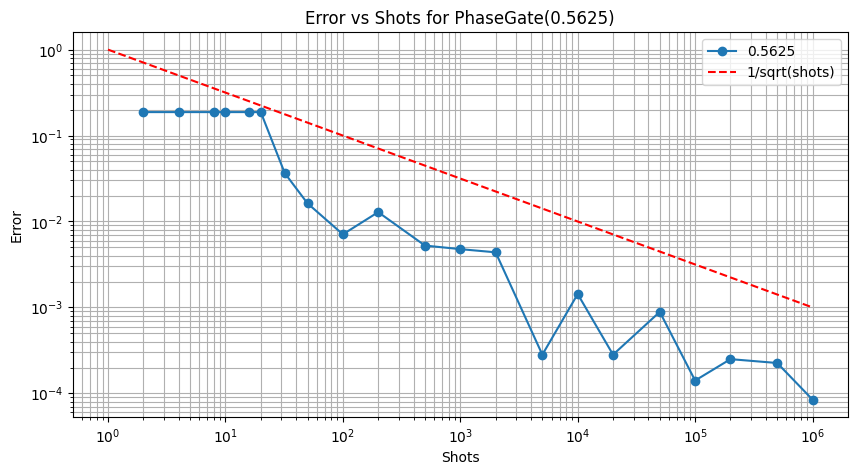

In [114]:
plt.figure(figsize=(10, 5))
plt.plot(shots_had_sim_5625, error_had_sim_5625, marker='o', label='0.5625')
x = np.linspace(1,1000000,1000)
y=1/np.sqrt(x)
plt.plot(x, y, label='1/sqrt(shots)', color='red', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Shots')
plt.ylabel('Error')
plt.title('Error vs Shots for PhaseGate(0.5625)')
plt.grid(which='both')
plt.legend()
plt.show()

NameError: name 'shots_had_sim_5625' is not defined

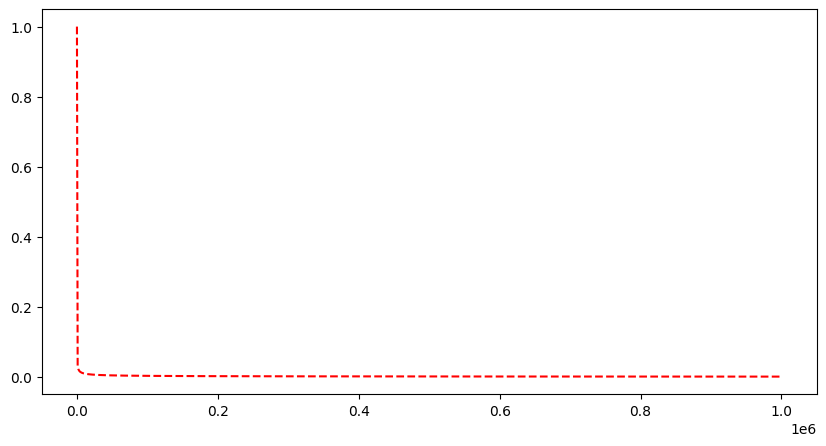

In [5]:
plt.figure(figsize=(10, 5))
x = np.linspace(1, 1000000, 1000)
y=1/np.sqrt(x)
plt.plot(x, y, label='1/sqrt(shots)', color='red', linestyle='--')
plt.plot(shots_had_sim_5625, error_had_sim_5625, marker='^', label='Error 0.5625', color='blue')
plt.plot(shots_had_sim_1234, error_had_sim_1234, marker='o', label='Error 0.1234', color='green')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Shots')
plt.ylabel('Error')
plt.title('Hadamard Test (Error vs Shots)on simulator')
plt.grid(visible=True, which="both", axis='both')
plt.legend()
plt.show()

### Qiskit Hardware Implementation

In [12]:
unitary = PhaseGate(2*np.pi*0.1234)
evec = Statevector.from_label('1')
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
epsilon = 0.001
delta = 0.01
# shots =1000
optimization_level = 3
backend.name

'ibm_sherbrooke'

In [17]:
angle, qc_re, qc_im, isa_qc_re, isa_qc_im, shots_re, shots_im, results_re, results_im, counts_re, counts_im, real, imaginary = Hadamard_test(unitary=unitary, evec=evec, epsilon=epsilon, delta=delta, backend=backend, optimization_level=optimization_level)

Parameters of Hadamard Test:
Backend: <IBMBackend('ibm_sherbrooke')>
Unitary: Instruction(name='p', num_qubits=1, num_clbits=0, params=[0.775345066905961])
Epsilon: 0.001
Success Probability: 0.99
Eigenvector: Statevector([0.+0.j, 1.+0.j],
            dims=(2,))
Initial state: Statevector([0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
            dims=(2, 2))
Optimization Level: 3


c:\Users\nihar\OneDrive-IndianInstituteofScience\IndianInstituteofScience\MTech_Thesis\Notes\codes\miniconda\envs\qiskit-env\Lib\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:903: UserWarning: Your current pending jobs are estimated to consume 1197.8821582597352 quantum seconds, but you only have 600 quantum seconds left in your monthly quota; therefore, it is likely this job will be canceled
  warnings.warn(warning_message)


RuntimeJobMaxTimeoutError: 'Error code 1305; Ran too long Increase `max execution time <https://docs.quantum.ibm.com/guides/max-execution-time>`__ or contact support.'

## Quantum Phase Estimation using Quantum Fourier Transform

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_distribution
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import PhaseEstimation, PhaseGate, Initialize
import numpy as np
import matplotlib.pyplot as plt

For example, taking the unitary matrix to be the phase gate as 

$T=\begin{pmatrix} 1 & 0 \\ 0 & e^{-2\pi\iota \phi} \end{pmatrix}$

and finding the phase corresponding to the $\ket{1}$ eigenvector

In [39]:
def QPE(unitary, evec, epsilon=0.001, delta = 0.01, shots = 1000, backend = AerSimulator(), optimization_level=3):

    # ancillas = int(int(np.log2(1/epsilon)) + np.ceil(np.log2(2+ 1/(2*delta))))
    ancillas = 2
    qubits = QuantumRegister(unitary.num_qubits + ancillas, 'q')
    cbits = ClassicalRegister(ancillas, 'c')
    circ = QuantumCircuit(qubits, cbits)
    zero = Statevector.from_label('0'*ancillas)
    initial_state = evec.tensor(zero)
    initialize_state = Initialize(initial_state)

    print("Parameters of Quantum Phase Estimation:")
    print("Backend:", backend)
    print("Unitary:", unitary)
    print("Eigenvector:", evec)
    print("Initial state:", initial_state)
    print("Success probability:", 1-delta)
    print("Number of Ancillas Qubits:", ancillas)
    print("Epsilon:", epsilon)
    print("Optimization Level:", optimization_level)

    qc = QuantumCircuit(unitary.num_qubits, name='U')
    qc.append(unitary, list(range(0,unitary.num_qubits)))

    circ.append(initialize_state, list(range(0,unitary.num_qubits+ancillas)))
    # Quantum Phase Estimation
    circ.barrier()
    circ.append(PhaseEstimation(ancillas, qc, name='QPE'), list(range(0,unitary.num_qubits+ancillas)))
    circ.barrier()
    circ.measure(list(range(0,ancillas)), list(range(0,ancillas)))
    
    # Shots
    # shots = 1/epsilon
    shots = shots
    pm = generate_preset_pass_manager(backend=backend, optimization_level=optimization_level)
    isa_circ = pm.run(circ)
    results = backend.run(isa_circ, shots=shots).result()
    counts = results.get_counts(isa_circ)
    
    max_bitstring = max(counts, key=counts.get)
    max_bitstring = max_bitstring[::-1]
    bitstring_int = int(max_bitstring, 2)
    angle = (bitstring_int/2**len(max_bitstring))

    return angle, circ, isa_circ, shots, results, counts

In [40]:
unitary = PhaseGate(2*np.pi*0.5352)
evec = Statevector.from_label('1')
backend = AerSimulator()
epsilon = 0.001
delta = 0.01
shots = 1000
optimization_level = 3

In [41]:
angle, circ, isa_circ, shots, results, counts = QPE(unitary=unitary, evec=evec, epsilon=epsilon, delta=delta,shots =shots, backend=backend, optimization_level=optimization_level)

Parameters of Quantum Phase Estimation:
Backend: AerSimulator('aer_simulator')
Unitary: Instruction(name='p', num_qubits=1, num_clbits=0, params=[3.3627607764025145])
Eigenvector: Statevector([0.+0.j, 1.+0.j],
            dims=(2,))
Initial state: Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2))
Success probability: 0.99
Number of Ancillas Qubits: 2
Epsilon: 0.001
Optimization Level: 3


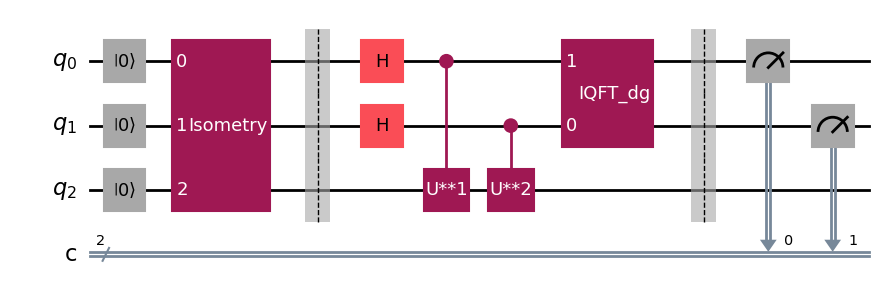

In [42]:
circ.decompose().decompose().draw(output='mpl')

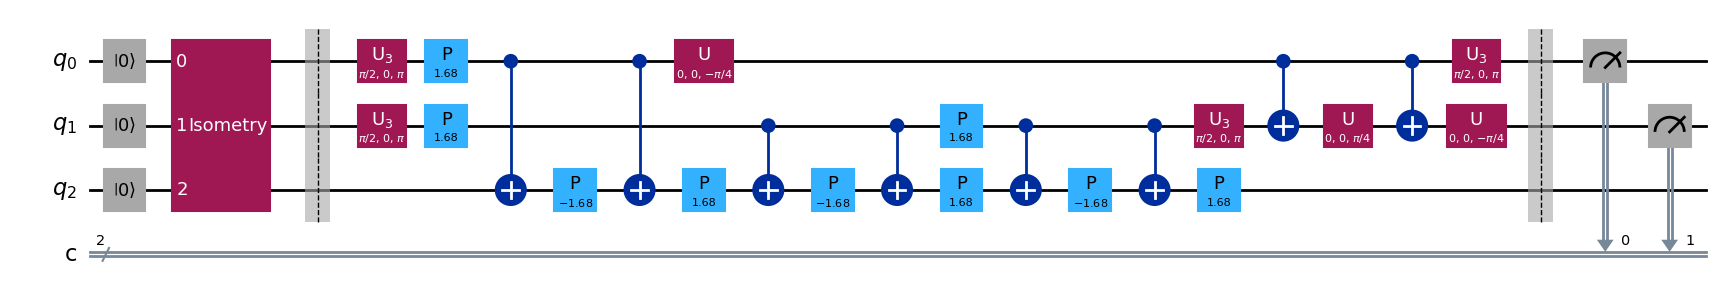

In [43]:
isa_circ.decompose().decompose().draw(output='mpl')

In [44]:
results

Result(backend_name='aer_simulator', backend_version='0.15.0', qobj_id='', job_id='bb1abc6f-8391-4152-a954-5802624cf0d6', success=True, results=[ExperimentResult(shots=1000, success=True, meas_level=2, data=ExperimentResultData(counts={'0x1': 933, '0x3': 26, '0x2': 27, '0x0': 14}), header=QobjExperimentHeader(creg_sizes=[['c', 2]], global_phase=0.0, memory_slots=2, n_qubits=3, name='circuit-5060968', qreg_sizes=[['q', 3]], metadata={}), status=DONE, seed_simulator=1669973086, metadata={'batched_shots_optimization': False, 'required_memory_mb': 1, 'method': 'statevector', 'active_input_qubits': [0, 1, 2], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 3, 'num_clbits': 2, 'time_taken': 0.0279353, 'sample_measure_time': 0.0052007, 'input_qubit_map': [[0, 0], [1, 1], [2, 2]], 'max_memory_mb': 7876, 'measure_sampling': True, 'noise': 'ideal', 'parallel_shots': 1, 'parallel_state_update': 12, 'runtime_parameter_bind': False, 'num_bind_params': 1, 'fusion': {'enabled': True, 'thresh

In [45]:
counts

{'01': 933, '11': 26, '10': 27, '00': 14}

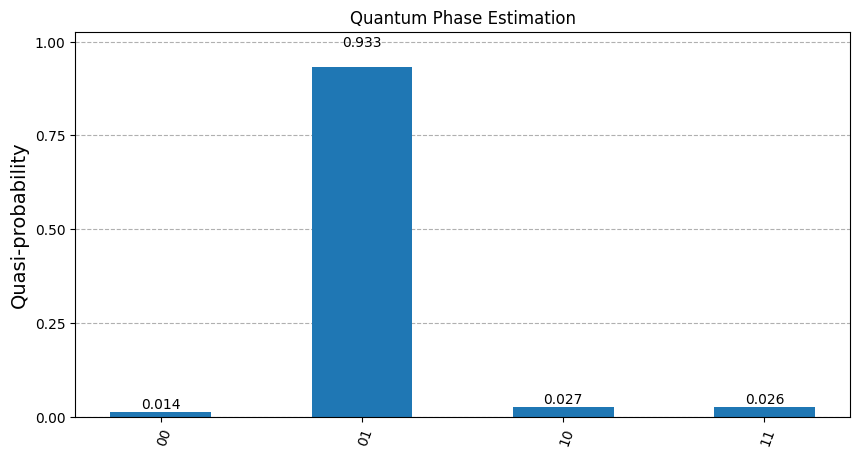

In [46]:
plot_distribution(results.get_counts(circ), title="Quantum Phase Estimation", figsize=(10, 5))

In [47]:
print("Angle:", angle)
print("Eigenvalue:", np.exp(2*np.pi*1j*angle))
print("Real p(0):", counts_re['0']/shots_re)
print("Real p(1):", counts_re['1']/shots_re)

Angle: 0.5
Eigenvalue: (-1+1.2246467991473532e-16j)


NameError: name 'counts_re' is not defined

In [ ]:
print(f'QPE angle: {angle} with shots = {shots} and error={epsilon} and success probabiltiy={1-delta}')

QPE angle: 0.0 with shots = 1000 and error=0.001 and success probabiltiy=0.99


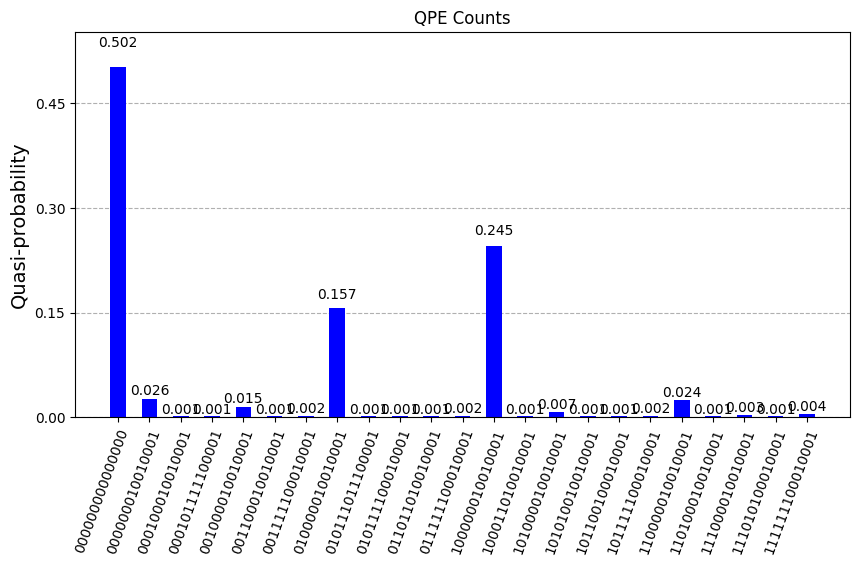

In [ ]:
plot_distribution(counts, title='QPE Counts', figsize=(10, 5), color='blue')

In [19]:
unitary = PhaseGate(2*np.pi*0.1234)
evec = Statevector.from_label('1')
backend = AerSimulator()
epsilon = 0.001
delta = 0.01
shots = 1000
optimization_level = 3

In [48]:
shots_qpe_sim_1234 = [2,4,8,10,16,20,32,50,100,200,300, 400, 500, 600, 700,800, 900, 1000]
error_qpe_sim_1234 = []
for shot in shots_qpe_sim_1234:
    angle, circ, isa_circ, shots, results, counts = QPE(unitary=unitary, evec=evec, epsilon=epsilon, delta=delta,shots =shot, backend=backend, optimization_level=optimization_level)
    error_qpe_sim_1234.append(abs(angle-0.1234))

Parameters of Quantum Phase Estimation:
Backend: AerSimulator('aer_simulator')
Unitary: Instruction(name='p', num_qubits=1, num_clbits=0, params=[3.3627607764025145])
Eigenvector: Statevector([0.+0.j, 1.+0.j],
            dims=(2,))
Initial state: Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2))
Success probability: 0.99
Number of Ancillas Qubits: 2
Epsilon: 0.001
Optimization Level: 3
Parameters of Quantum Phase Estimation:
Backend: AerSimulator('aer_simulator')
Unitary: Instruction(name='p', num_qubits=1, num_clbits=0, params=[3.3627607764025145])
Eigenvector: Statevector([0.+0.j, 1.+0.j],
            dims=(2,))
Initial state: Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2))
Success probability: 0.99
Number of Ancillas Qubits: 2
Epsilon: 0.001
Optimization Level: 3
Parameters of Quantum Phase Estimation:
Backend: AerSimulator('aer_simulator')
Uni

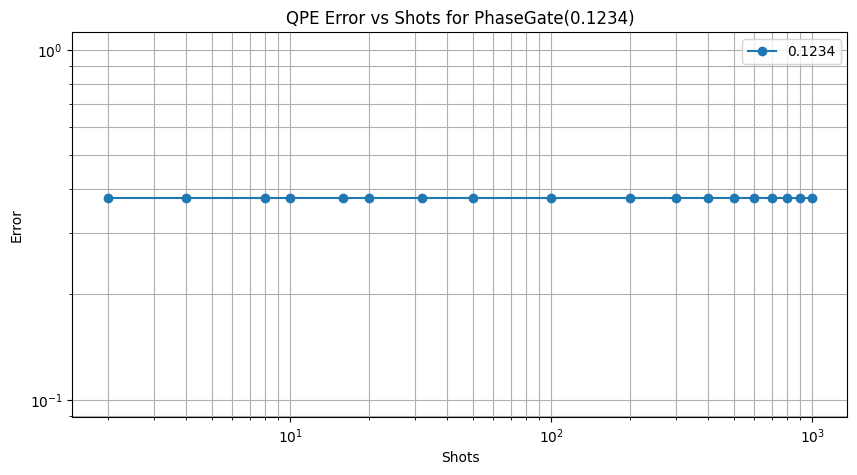

In [49]:
# PLot
# PLot error vs shots
plt.figure(figsize=(10, 5))
plt.plot(shots_qpe_sim_1234, error_qpe_sim_1234, marker='o', label='0.1234')
x = np.linspace(1,1000,1000)
y = 1/x
# plt.plot(x, y, label='1/shots', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Shots')
plt.ylabel('Error')
plt.title('QPE Error vs Shots for PhaseGate(0.1234)')
plt.grid(which='both')
plt.legend()
plt.show()

In [50]:
unitary = PhaseGate(2*np.pi*0.5626)
evec = Statevector.from_label('1')
backend = AerSimulator()
epsilon = 0.001
delta = 0.01
shots = 1000
optimization_level = 3

In [51]:
shots_qpe_sim_5625 = [2,4,8,10,16,20,32,50,100,200,300, 400, 500, 600, 700, 800, 900, 1000]
error_qpe_sim_5625 = []
for shot in shots_qpe_sim_5625:
    angle, circ, isa_circ, shots, results, counts = QPE(unitary=unitary, evec=evec, epsilon=epsilon, delta=delta,shots =shot, backend=backend, optimization_level=optimization_level)
    error_qpe_sim_5625.append(abs(angle-0.5625))

Parameters of Quantum Phase Estimation:
Backend: AerSimulator('aer_simulator')
Unitary: Instruction(name='p', num_qubits=1, num_clbits=0, params=[3.5349200538192354])
Eigenvector: Statevector([0.+0.j, 1.+0.j],
            dims=(2,))
Initial state: Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2))
Success probability: 0.99
Number of Ancillas Qubits: 2
Epsilon: 0.001
Optimization Level: 3
Parameters of Quantum Phase Estimation:
Backend: AerSimulator('aer_simulator')
Unitary: Instruction(name='p', num_qubits=1, num_clbits=0, params=[3.5349200538192354])
Eigenvector: Statevector([0.+0.j, 1.+0.j],
            dims=(2,))
Initial state: Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2))
Success probability: 0.99
Number of Ancillas Qubits: 2
Epsilon: 0.001
Optimization Level: 3
Parameters of Quantum Phase Estimation:
Backend: AerSimulator('aer_simulator')
Uni

In [52]:
print(error_qpe_sim_5625)

[0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625]


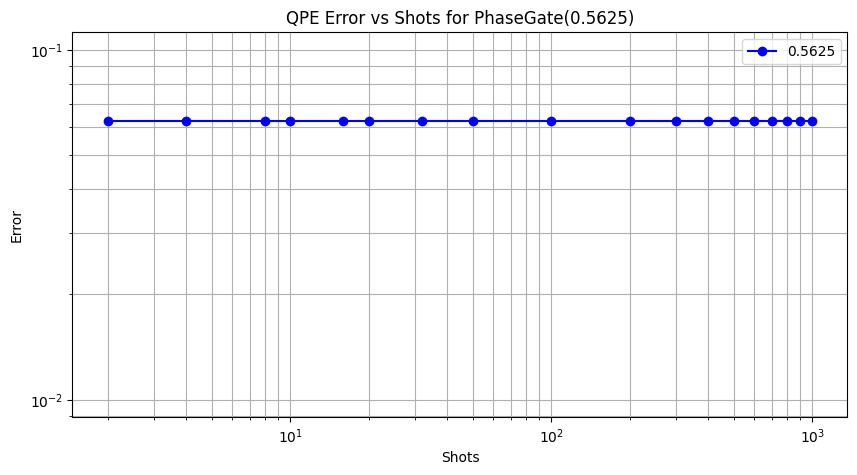

In [53]:
# PLot
# PLot error vs shots
plt.figure(figsize=(10, 5))
plt.plot(shots_qpe_sim_5625, error_qpe_sim_5625, marker='o', label='0.5625', color='blue')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Shots')
plt.ylabel('Error')
plt.title('QPE Error vs Shots for PhaseGate(0.5625)')
plt.grid(which='both')
plt.legend()
plt.show()

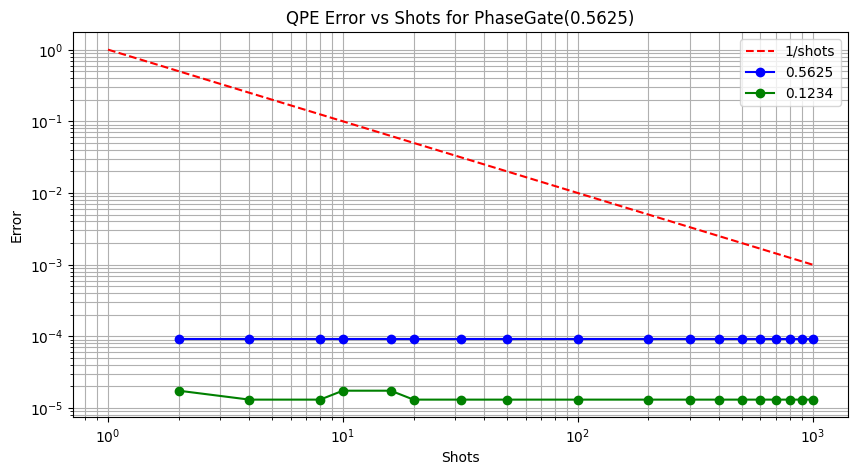

In [23]:
# PLot
# PLot error vs shots
plt.figure(figsize=(10, 5))
x = np.linspace(1,1000,1000)
y = 1/x
plt.plot(x, y, label='1/shots', linestyle='--', color='red')
plt.plot(shots_qpe_sim_5625, error_qpe_sim_5625, marker='o', label='0.5625', color='blue')
plt.plot(shots_qpe_sim_1234, error_qpe_sim_1234, marker='o', label='0.1234', color='green')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Shots')
plt.ylabel('Error')
plt.title('QPE Error vs Shots for PhaseGate(0.5625)')
plt.grid(which='both')
plt.legend()
plt.show()

In [55]:
from qiskit import QuantumCircuit
 
qc = QuantumCircuit(5, 5)
qc.x(0)
qc.x(1)
qc.x(4)
qc.measure(range(5), range(5))

backend = AerSimulator()
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_qc = pm.run(qc)
results = backend.run(isa_qc, shots=1000).result()
counts = results.get_counts(isa_qc)

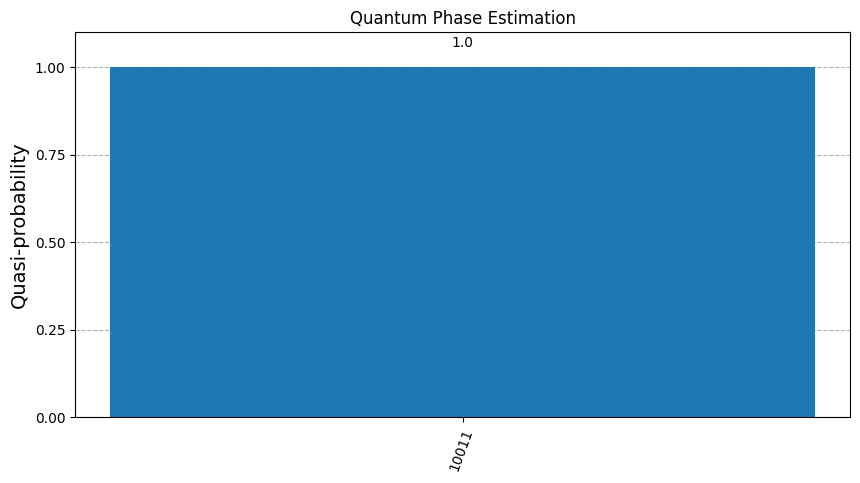

In [57]:
plot_distribution(results.get_counts(qc), title="Quantum Phase Estimation", figsize=(10, 5))